For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    # Selecting starting point as random from [0,1] we select random phase of the signal
    #By adding 10,15,7 we set frequency of the line
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n)) 
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [5]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)
    

[False False False False  True]


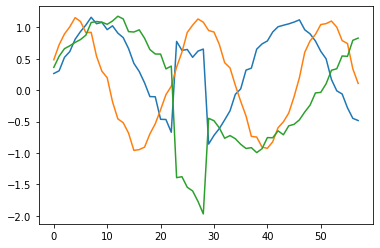

[False False False  True  True]


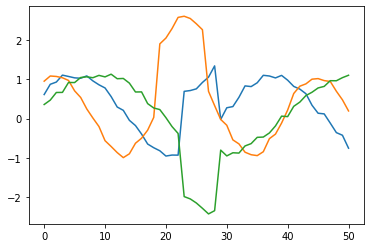

[False False False False False]


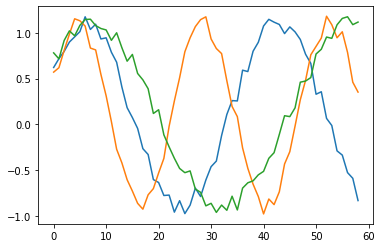

[ True False False False  True]


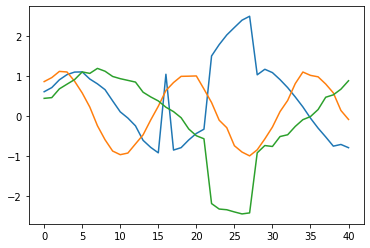

[False  True False False False]


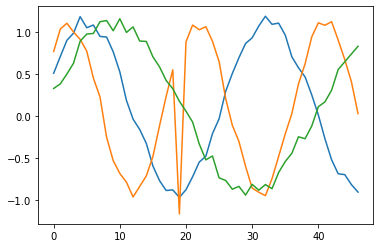

In [6]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

#### Small analysis

Assuming I know nothing about the signal lets check at first if these all have same lengths


In [36]:
type(xl), xl[0].shape, xl[1].shape #Clearly shapes don't match, we have 3 signals but their shapes differ

(list, (58, 3), (51, 3))

Lets see some statistics of these signal lengths. So signals are in range [40:60) and their length is uniformly distributed. <br>
So we can either pad all of them to match 59 once, or we can pad them dynamically. But since distribution is uniform and we have only 20 these values. For batch size like 512 we will end up padding them to 59 anyways. So we will pad them once

0,25,50,75, 100 quantiles: [40. 44. 49. 55. 59.]


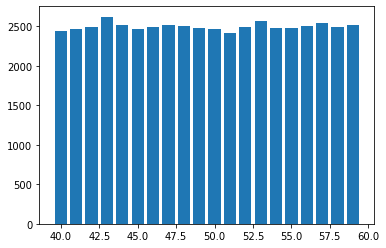

In [37]:
seq_lengths = np.array(list(map(lambda x: x.shape[0], xl)))
plt.bar(*np.unique(seq_lengths, return_counts=True))
print(f"0,25,50,75, 100 quantiles: {np.quantile(seq_lengths, [0,0.25,0.5,0.75,1])}")

#### Let's see if we could get some insights calculating means and std of the data

In [38]:
seq_stats = pd.DataFrame(map(lambda x: (*x[0].mean(axis=0), *x[0].std(axis=0),*x[1]), zip(xl,yl)), columns=[f"mean{i}" for i in range(3)] +[f"std{i}" for i in range(3)] + [f"def{i}" for i in range(5)])

In [39]:
seq_stats = seq_stats.iloc[np.random.choice(np.arange(n), size=n//5, replace=False),:] # filter the data so that plotly dpesn't die. Trends should be still visible
seq_stats_melted = pd.melt(seq_stats, id_vars=['mean0', 'mean1', 'mean2', 'std0', 'std1','std2'], value_vars=['def0','def1','def2','def3','def4' ])

In [40]:
#px.strip(seq_stats_melted, x="mean0", color="value", facet_col="variable")


In [41]:
#px.strip(seq_stats_melted, x="std1", color="value", facet_col="variable")


In [42]:
#px.strip(seq_stats_melted, x="mean1", color="value", facet_col="variable")


In [43]:
#px.strip(seq_stats_melted, x="mean2", color="value", facet_col="variable")


#### Try applying smoothing techniques to get original signal and find anomalies
If we believed that these perturbances are quite local we may try to smooth the signal and find outliers via subtraction. Next we can just select biggest residual from the signal

Boundary effect. THis may happens here and detriment LSTM work

In [44]:
def smooth(x,window_len=11,window='hanning'):
    """Function taken from https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html"""
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2-1):-(window_len//2)]

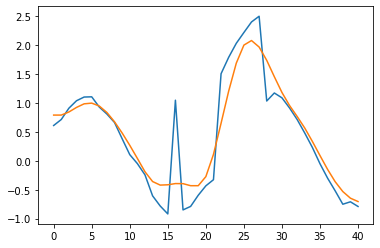

In [45]:
plt.plot(xl[3][:,0])
plt.plot(smooth(xl[3][:,0], window_len = 10))


So now one should just check if this works for all data by selecting biggest residual

#### Using derivative

We may check if these defects might have been created by some transients in the signal.

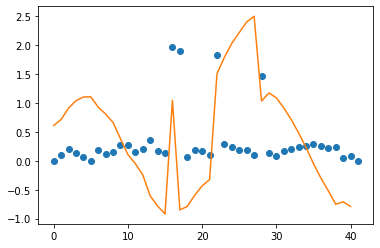

In [46]:
from scipy.signal import convolve

analyzed_signal = xl[3][:,0]
analyzed_signal = np.concatenate([[analyzed_signal[0]], analyzed_signal, [analyzed_signal[-1]]])
plt.plot(np.abs(convolve(analyzed_signal, [1,-1]))[1:-1], linestyle='None', marker="o") #first order derivative approximation
plt.plot(xl[3][:,0]) #first order derivative approximation

So calculate this derivatives for all plots and see how well this can do

## DL approach

In [7]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import tensorflow.keras.backend as K
import tensorflow as tf
import logging


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Firstly, we should split the data into train/test/val sets

In [9]:
x = []
for series in xl:
    if len(series) < 60:
        tmp = np.concatenate([series, np.zeros((60-len(series),3))]) #pad with zeros
    x.append(tmp)

In [10]:
x, yl = np.array(x), np.array(yl)


In [11]:
x.shape, yl.shape

((50000, 60, 3), (50000, 5))

In [12]:
train_split = 0.8
val_split = 0.9

split1 = int(len(x)*train_split)
split2 =  int(len(x)*val_split)

train_x, train_y = x[:split1], yl[:split1]
val_x, val_y = x[split1:split2], yl[split1:split2]
test_x, test_y = x[split2:], yl[split2:]


In [13]:
train_x.shape, train_y.shape

((40000, 60, 3), (40000, 5))

Then, we can add a basic model - SimpleRNN

In [54]:
simple_model = Sequential()
simple_model.add(SimpleRNN(32, input_shape=(None,3)))
simple_model.add(Dense(5, activation='sigmoid'))
simple_model.compile(loss='binary_crossentropy', metrics=[
              tf.keras.metrics.BinaryAccuracy()])
simple_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1152      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,317
Trainable params: 1,317
Non-trainable params: 0
_________________________________________________________________


In [55]:
early = EarlyStopping(patience=7, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=6)
simple_model.fit(train_x, train_y, batch_size=64, epochs=50,
          validation_data=(val_x, val_y), callbacks=[early])


Epoch 1/50
625/625 [==============================] - 21s 31ms/step - loss: 0.4798 - binary_accuracy: 0.7872 - val_loss: 0.4386 - val_binary_accuracy: 0.8020
Epoch 2/50
625/625 [==============================] - 20s 31ms/step - loss: 0.4398 - binary_accuracy: 0.8123 - val_loss: 0.3944 - val_binary_accuracy: 0.8334
Epoch 3/50
625/625 [==============================] - 19s 31ms/step - loss: 0.4292 - binary_accuracy: 0.8158 - val_loss: 0.4426 - val_binary_accuracy: 0.8169
Epoch 4/50
625/625 [==============================] - 19s 31ms/step - loss: 0.4159 - binary_accuracy: 0.8205 - val_loss: 0.3921 - val_binary_accuracy: 0.8378
Epoch 5/50
625/625 [==============================] - 19s 30ms/step - loss: 0.4299 - binary_accuracy: 0.8135 - val_loss: 0.3764 - val_binary_accuracy: 0.8388
Epoch 6/50
625/625 [==============================] - 21s 33ms/step - loss: 0.4685 - binary_accuracy: 0.7994 - val_loss: 0.3934 - val_binary_accuracy: 0.8320
Epoch 7/50
625/625 [==============================] 

In [56]:
simple_model.evaluate(test_x, test_y)

157/157 [==============================] - 2s 14ms/step - loss: 0.3242 - binary_accuracy: 0.8513


[0.32424014806747437, 0.8512799739837646]

The simplest RNN gives us validation and test accuracy of ~85%. It's pretty decent, but we can do better. Let's try with one LSTM layer now.

In [57]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, 3)))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=[
              tf.keras.metrics.BinaryAccuracy()])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17408     
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 17,733
Trainable params: 17,733
Non-trainable params: 0
_________________________________________________________________


In [58]:
early = EarlyStopping(patience=7, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=6)
model_checkpoint = ModelCheckpoint(filepath="best_weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5",save_weights_only=True,
                                    monitor='val_binary_accuracy', mode='max', save_best_only=True)
model.fit(train_x, train_y, batch_size=64, epochs=50,
          validation_data=(val_x, val_y), callbacks=[early, reduce, model_checkpoint])

Epoch 1/50
625/625 [==============================] - 11s 14ms/step - loss: 0.4320 - binary_accuracy: 0.8104 - val_loss: 0.3947 - val_binary_accuracy: 0.8386 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 8s 12ms/step - loss: 0.3127 - binary_accuracy: 0.8634 - val_loss: 0.4177 - val_binary_accuracy: 0.8067 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 8s 12ms/step - loss: 0.2667 - binary_accuracy: 0.8859 - val_loss: 0.2285 - val_binary_accuracy: 0.9064 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 8s 12ms/step - loss: 0.2454 - binary_accuracy: 0.8956 - val_loss: 0.2367 - val_binary_accuracy: 0.9003 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 8s 12ms/step - loss: 0.2299 - binary_accuracy: 0.9017 - val_loss: 0.2043 - val_binary_accuracy: 0.9097 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 8s 12ms/step - loss: 0.2150 - binary_accuracy: 0.9076 - val_loss: 0.1981 - val_binary_accuracy:

In [59]:
model.evaluate(val_x, val_y)


157/157 [==============================] - 1s 7ms/step - loss: 0.0109 - binary_accuracy: 0.9966


[0.010908040218055248, 0.9965999722480774]

In [60]:
model.evaluate(test_x, test_y)

157/157 [==============================] - 1s 7ms/step - loss: 0.0105 - binary_accuracy: 0.9968


[0.01052768062800169, 0.9968000054359436]

Lets make sure that padding hasn't influenced anything, as signals are quite short. It doesn't look so as if it indeed biased model towards something we probably won't be getting such good accuracy.

In [61]:
from collections import defaultdict
test_x_no_pad = xl[split2:]

In [62]:
#!passing every element separately is quite slow, but such a sanity check should be done
results_no_pad = np.array([model.predict(x[None,:,:], verbose=0) for x in test_x_no_pad])

In [63]:
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(yl[split2:], results_no_pad[:,0,:])
acc.result().numpy()

0.99212

In [64]:
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(yl[split2:], model.predict(test_x))
acc.result().numpy()

157/157 [==============================] - 1s 5ms/step


0.9968

Small deterioration is visible this may be because this additional padding allows model to saturate more when it already have seen the output?

In [65]:
#Lets make small redefinition of the model, and train it so that the maximum prediction should be correct. Now model doesn't have to saturate till very end
#But just needs to fire at specific moment
model = Sequential()
model.add(LSTM(64, input_shape=(None, 3), return_sequences=True))
model.add(Dense(5))
model.add(tf.keras.layers.GlobalMaxPooling1D())#! Now this is enough to remove this GlobalMaxPooling and explainability would be done in one shot (hopefully)
model.add(tf.keras.layers.Activation("sigmoid"))
model.compile(loss='binary_crossentropy', metrics=[
              tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 64)          17408     
                                                                 
 dense_4 (Dense)             (None, None, 5)           325       
                                                                 
 global_max_pooling1d (Globa  (None, 5)                0         
 lMaxPooling1D)                                                  
                                                                 
 activation (Activation)     (None, 5)                 0         
                                                                 
Total params: 17,733
Trainable params: 17,733
Non-trainable params: 0
_________________________________________________________________


In [66]:
early = EarlyStopping(patience=7, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=6)
model_checkpoint = ModelCheckpoint(filepath="best_weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5",save_weights_only=True,
                                    monitor='val_binary_accuracy', mode='max', save_best_only=True)
model.fit(train_x, train_y, batch_size=64, epochs=50,
          validation_data=(val_x, val_y), callbacks=[early, reduce, model_checkpoint])

Epoch 1/50
625/625 [==============================] - 10s 14ms/step - loss: 0.4655 - binary_accuracy: 0.8065 - val_loss: 0.3511 - val_binary_accuracy: 0.8500 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 8s 13ms/step - loss: 0.3226 - binary_accuracy: 0.8626 - val_loss: 0.2304 - val_binary_accuracy: 0.9110 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 8s 13ms/step - loss: 0.2249 - binary_accuracy: 0.9053 - val_loss: 0.2161 - val_binary_accuracy: 0.9131 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 8s 13ms/step - loss: 0.1941 - binary_accuracy: 0.9199 - val_loss: 0.1311 - val_binary_accuracy: 0.9608 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 8s 13ms/step - loss: 0.0730 - binary_accuracy: 0.9788 - val_loss: 0.0361 - val_binary_accuracy: 0.9902 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 8s 13ms/step - loss: 0.0278 - binary_accuracy: 0.9919 - val_loss: 0.0196 - val_binary_accuracy:

In [67]:
results_no_pad = np.array([model.predict(x[None,:,:], verbose=0) for x in test_x_no_pad])

In [68]:
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(yl[split2:], results_no_pad[:,0,:])
acc.result().numpy()

0.99808

We obtain very good results - 99.7% binary accuracy on the both test and validation data. It doesn't make any sense to train it further.

Now let's try to get the exact place of the anomaly. Firstly we use Gradient*Input method. It's an explainability measure of each input.

In [45]:
def get_gradient(input_, top_class):
    x_tensor = tf.cast(input_, tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        output = model(x_tensor)[:,top_class]

    result = output
    gradients = t.gradient(output, x_tensor) # By default it is averaged so I don't get derivative w.r.t each output separately :(
    return gradients.numpy()

In [51]:
model = tf.keras.models.load_model('lstm')

In [52]:
model.predict(train_x[0][None,:,:]), train_y[0]

1/1 [==============================] - 1s 576ms/step


(array([[1.1032342e-03, 8.9072058e-04, 6.7998469e-03, 2.1722357e-07,
         9.9999940e-01]], dtype=float32),
 array([False, False, False, False,  True]))

In [53]:
gradients_numpy = get_gradient(train_x[0][None,:,:], 4) # 4 is a class for which we want to know the gradient

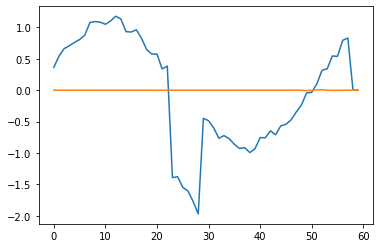

In [54]:
plt.plot(x[0][:,2])
plt.plot(gradients_numpy[0,:,2] * 1000)      

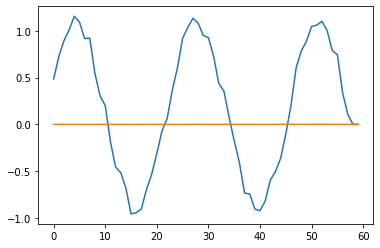

In [55]:
plt.plot(x[0][:,1])
plt.plot(gradients_numpy[0,:,1] * 1000)      

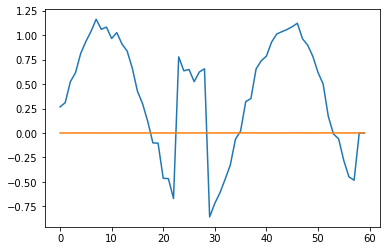

In [56]:
plt.plot(x[0][:,0])
plt.plot(gradients_numpy[0,:,0] * 1000)      

As one can observe simple gradients are not enough. This is mainly because network become very confident and saturated for one prediction. Small changes won't change anything. That's why we want to use `integrated gradients`.

In [57]:
def get_integrated_gradients(example, classes_to_show, baseline=None, n_steps = 5, plot_interpolation = None):
    if baseline is None:
        baseline = np.zeros((60,3)).astype(np.float32)

    num_steps = 5
    interpolated_signal = [
            baseline + (step / num_steps) * (example - baseline)
            for step in range(num_steps + 1)
        ]
    interpolated_signal = np.array(interpolated_signal).astype(np.float32)

    if plot_interpolation is not None:
        for i in plot_interpolation:
            plt.plot(interpolated_signal[i])
            plt.plot(example)
            plt.show()
    
    grads = []
    for i, img in enumerate(interpolated_signal):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradient(img, classes_to_show)
        grads.append(grad[0])
    grads = np.array(grads)

    grads = (grads[:-1] + grads[1:]) / 2.0 # I calculate this area pointwise, for every point, and i doing it over dnum_steps
    avg_grads = grads.mean(axis=0)

    integrated_grads = (example - baseline) * avg_grads

    return integrated_grads

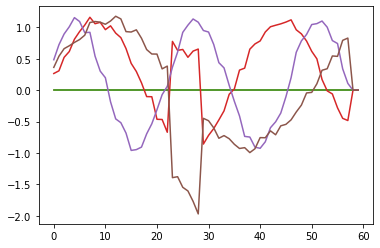

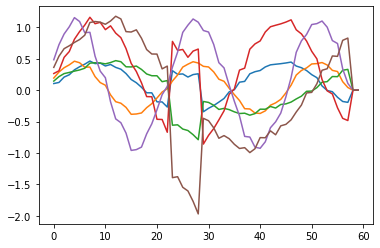

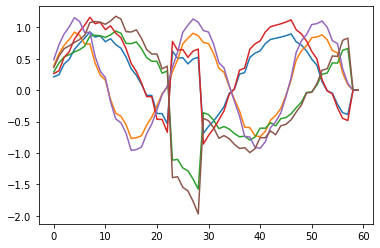

In [58]:
example = train_x[0]
top_prediction = 4
integrated_grads = get_integrated_gradients(example, top_prediction, plot_interpolation=[0,2,4])

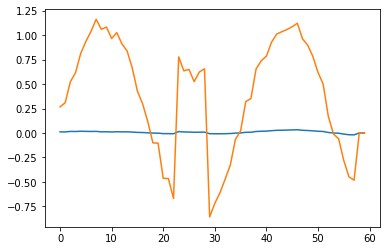

In [61]:
plt.plot(integrated_grads[:,0] * 10)
plt.plot(example[:,0])

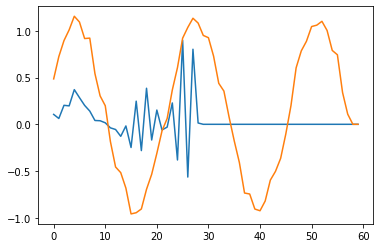

In [78]:
plt.plot(integrated_grads[:,1] * 10)
plt.plot(example[:,1])

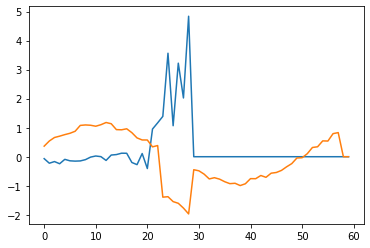

In [79]:
plt.plot(integrated_grads[:,2] * 10)
plt.plot(example[:,2])

This kind of makes sense but its still nonsatisfactory, probably a better baseline is needed. Comment for our model withouth GlobalMaxPooling

With GlobalMaxPooling this works wonderfully


In [80]:
my_baseline = []
for i in range(3):
    my_baseline.append(smooth(example[:,i], window_len = 20))
my_baseline = np.array(my_baseline).T

In [81]:
my_baseline.shape

(60, 3)

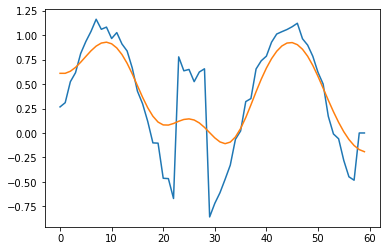

In [82]:
plt.plot(example[:,0])
plt.plot(my_baseline[:,0])

In [83]:
#! Blurred baseline
example = train_x[0]
top_prediction = 4
integrated_grads = get_integrated_gradients(example, top_prediction,baseline=my_baseline, n_steps=50)#, plot_interpolation=[0,2,4])

In [84]:
integrated_grads.shape

(60, 3)

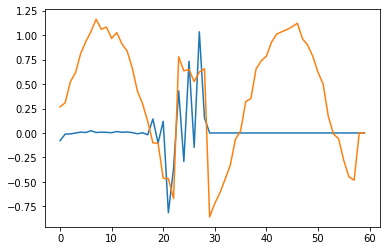

In [85]:
plt.plot(integrated_grads[:,0]*10)
plt.plot(example[:,0])

In [44]:
plt.plot(integrated_grads[:,1]*10, )
plt.plot(example[:,1])

NameError: name 'integrated_grads' is not defined

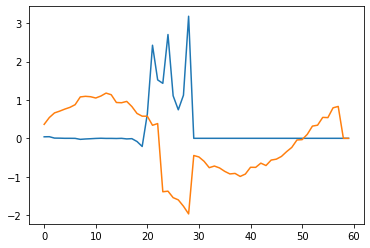

In [87]:
plt.plot(integrated_grads[:,2]*10)
plt.plot(example[:,2])

This approach work much better for the model withough GlobalMaxPooling

In [88]:
#!Uniform baseline
example = train_x[0]
top_prediction = 4
integrated_grads = get_integrated_gradients(example, top_prediction,baseline=np.random.uniform(0,1,(60,3)), n_steps=50)

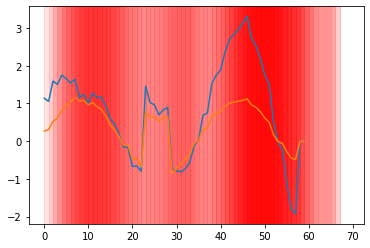

In [97]:
plt.plot(integrated_grads[:,0]*1000)
plt.plot(example[:,0])

for i in range(len(integrated_grads)):
    q = integrated_grads[i,0]
    plt.axvspan(i, i+10, color='red', alpha=abs(q)*100)


Now we can try to explain the model using basic probing approach. Firstly we split the signals to slices, and then fit the model on those slices

In [14]:
miniModel = Sequential()
miniModel.add(LSTM(64, return_sequences=True, input_shape=(None, 3)))
miniModel.add(LSTM(16, return_sequences=False))
miniModel.add(Dense(5, activation='sigmoid'))
miniModel.summary()
miniModel.compile(loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          17408     
                                                                 
 lstm_1 (LSTM)               (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 22,677
Trainable params: 22,677
Non-trainable params: 0
_________________________________________________________________


In [15]:
x_model = Sequential()
x_model.add(Reshape((-1, 10, 3), input_shape=(60, 3)))
x_model.add(TimeDistributed(miniModel))
x_model.add(GlobalMaxPool1D())
x_model.compile(loss='binary_crossentropy', metrics=[
                tf.keras.metrics.BinaryAccuracy()])
x_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 6, 10, 3)          0         
                                                                 
 time_distributed (TimeDistr  (None, 6, 5)             22677     
 ibuted)                                                         
                                                                 
 global_max_pooling1d (Globa  (None, 5)                0         
 lMaxPooling1D)                                                  
                                                                 
Total params: 22,677
Trainable params: 22,677
Non-trainable params: 0
_________________________________________________________________


In [16]:
early = EarlyStopping(patience=7, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=6)
x_model.fit(train_x, train_y, batch_size=256,
              epochs=50, validation_data=(val_x, val_y), callbacks=[early, reduce])


Epoch 1/50
157/157 [==============================] - 22s 29ms/step - loss: 0.5122 - binary_accuracy: 0.7787 - val_loss: 0.4284 - val_binary_accuracy: 0.8200 - lr: 0.0010
Epoch 2/50
157/157 [==============================] - 3s 21ms/step - loss: 0.4025 - binary_accuracy: 0.8319 - val_loss: 0.3832 - val_binary_accuracy: 0.8394 - lr: 0.0010
Epoch 3/50
157/157 [==============================] - 3s 19ms/step - loss: 0.3713 - binary_accuracy: 0.8419 - val_loss: 0.3544 - val_binary_accuracy: 0.8497 - lr: 0.0010
Epoch 4/50
157/157 [==============================] - 3s 19ms/step - loss: 0.3504 - binary_accuracy: 0.8492 - val_loss: 0.3988 - val_binary_accuracy: 0.8232 - lr: 0.0010
Epoch 5/50
157/157 [==============================] - 3s 18ms/step - loss: 0.3346 - binary_accuracy: 0.8572 - val_loss: 0.3482 - val_binary_accuracy: 0.8504 - lr: 0.0010
Epoch 6/50
157/157 [==============================] - 3s 19ms/step - loss: 0.3190 - binary_accuracy: 0.8670 - val_loss: 0.3135 - val_binary_accuracy:

In [17]:
x_model.evaluate(test_x, test_y)

157/157 [==============================] - 1s 8ms/step - loss: 0.0135 - binary_accuracy: 0.9960


[0.013529029674828053, 0.995959997177124]

We obtained similar results of 99.66% accuracy on validation data, and 99.59% on test data. Now we can look, where the signals were corrupted

In [18]:
model2 = Model(inputs=x_model.layers[0].input,
               outputs=x_model.layers[-2].output)
model2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_input (InputLayer)  [(None, 60, 3)]           0         
                                                                 
 reshape (Reshape)           (None, 6, 10, 3)          0         
                                                                 
 time_distributed (TimeDistr  (None, 6, 5)             22677     
 ibuted)                                                         
                                                                 
Total params: 22,677
Trainable params: 22,677
Non-trainable params: 0
_________________________________________________________________


In [35]:
test_x.shape

(5000, 60, 3)

1/1 [==============================] - 0s 36ms/step
[False False  True False False]
[1.6429014e-05 7.6159859e-06 8.1369599e-06 1.9641189e-05 1.8802566e-05
 5.3008935e-06]
[4.1116102e-05 1.0069739e-04 4.6139973e-04 3.0952786e-05 1.6649951e-04
 3.7185146e-05]
[4.9829623e-04 2.6470996e-03 2.4932309e-04 9.9986947e-01 1.6151116e-03
 7.0631533e-04]
[1.5081338e-05 1.0169591e-06 4.2138498e-05 2.7054333e-05 2.6172720e-06
 4.4935441e-06]
[2.0144182e-06 9.0364347e-06 1.7636197e-05 1.5088114e-05 9.1046240e-06
 1.1191297e-06]


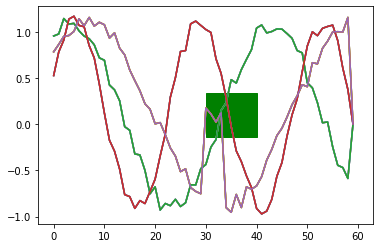

1/1 [==============================] - 0s 34ms/step
[False False False False  True]
[1.7450193e-05 2.5966394e-05 6.3360917e-06 5.5368237e-06 1.7056553e-05
 1.2204344e-05]
[4.6455254e-05 3.8455488e-04 2.4729889e-04 1.3217665e-04 8.2032595e-05
 2.2411659e-04]
[0.00034664 0.00339134 0.00014994 0.00062723 0.00099033 0.00059308]
[1.3673947e-05 3.7251590e-05 2.9901359e-05 5.4046586e-07 2.0243265e-06
 6.1422238e-06]
[2.0274720e-06 9.9998021e-01 1.5608008e-05 3.8243206e-06 7.8304074e-06
 2.8254631e-06]


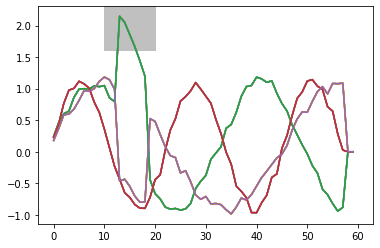

1/1 [==============================] - 0s 30ms/step
[ True False  True False False]
[7.5181038e-06 7.1072150e-06 9.9753261e-01 2.7895465e-05 7.7461655e-06
 2.3007017e-06]
[7.6614080e-05 7.6451834e-05 8.7620167e-04 9.3382230e-05 6.6466135e-05
 6.8558526e-05]
[2.5566493e-04 8.3470764e-04 9.9997044e-01 8.4974878e-03 5.1184598e-04
 6.9646887e-04]
[7.4311820e-06 1.6117103e-06 1.2527654e-05 3.3809995e-06 4.4055223e-06
 8.4258005e-07]
[7.3948158e-06 1.9187357e-06 1.6094038e-05 4.4656649e-06 1.2736242e-06
 1.8824958e-05]


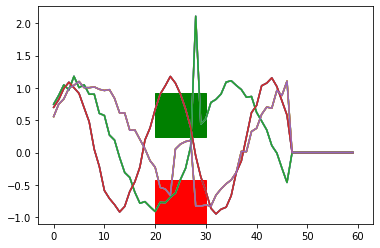

1/1 [==============================] - 0s 31ms/step
[False False False False False]
[9.9848939e-06 7.0540323e-06 5.2232676e-06 1.1282050e-05 1.4176227e-05
 2.3007017e-06]
[7.8827958e-05 5.2701304e-05 4.0691570e-04 5.7764744e-05 1.2814986e-04
 6.8558526e-05]
[0.00030972 0.00117604 0.0002418  0.00843433 0.0005783  0.00069647]
[7.2955650e-06 1.4592872e-06 4.1084759e-06 1.7906890e-06 5.4244842e-06
 8.4258005e-07]
[4.7157632e-06 1.4185489e-06 1.0273374e-05 6.8140262e-06 2.0059888e-06
 1.8824958e-05]


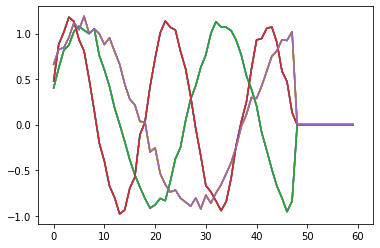

1/1 [==============================] - 0s 23ms/step
[False False False False False]
[1.1193495e-05 1.0595763e-05 2.4685842e-06 2.5295280e-05 6.0307684e-06
 2.3007017e-06]
[3.6111822e-05 4.9441405e-05 9.7217056e-04 1.1974681e-04 1.9059904e-05
 6.8558526e-05]
[0.0004467  0.00283818 0.00061429 0.00103078 0.00110189 0.00069647]
[4.4845710e-06 5.2994787e-06 3.9528395e-06 2.5495506e-06 3.2975929e-06
 8.4258005e-07]
[1.6037129e-06 2.4245344e-06 4.3416145e-05 5.3489998e-06 4.5583070e-07
 1.8824958e-05]


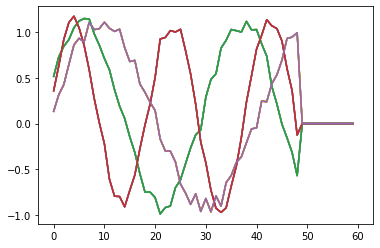

1/1 [==============================] - 0s 33ms/step
[ True False  True  True False]
[9.9997818e-01 1.7393204e-05 4.0325012e-06 5.6710878e-06 3.4288914e-06
 2.3007017e-06]
[4.43815021e-04 5.62848477e-03 1.86441088e-04 1.14029375e-04
 3.19470601e-05 6.85585255e-05]
[2.6320165e-04 9.9996638e-01 2.2097223e-04 9.6232950e-04 5.4455700e-04
 6.9646887e-04]
[9.9992776e-01 2.8525148e-05 1.0944872e-06 3.9228375e-06 1.8682723e-06
 8.4258005e-07]
[1.04098190e-05 6.16460165e-05 1.04169385e-05 1.83635475e-05
 5.58364536e-06 1.88249578e-05]


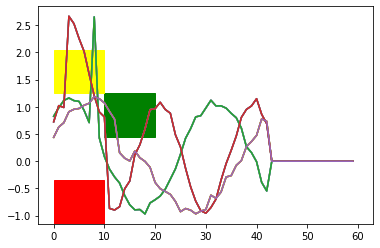

1/1 [==============================] - 0s 23ms/step
[False False False False False]
[1.2359572e-05 1.0447641e-05 5.3319536e-06 4.9465320e-06 5.6198178e-06
 2.3007017e-06]
[4.8447921e-05 5.9091613e-05 1.6019960e-04 9.7030432e-05 1.2473078e-04
 6.8558526e-05]
[0.00038345 0.00134561 0.00025827 0.00119587 0.00289201 0.00069647]
[7.4523737e-06 1.9409219e-05 7.8658986e-06 4.7635305e-07 6.5035260e-07
 8.4258005e-07]
[2.5244317e-06 6.8531731e-06 2.7435353e-05 4.6694631e-06 1.9475597e-06
 1.8824958e-05]


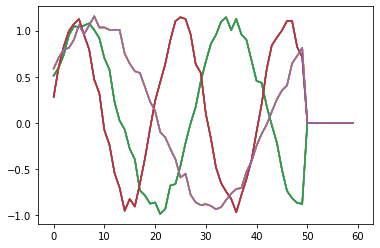

1/1 [==============================] - 0s 24ms/step
[False False False  True False]
[7.2062389e-06 9.2297005e-06 3.7344555e-06 2.4746070e-05 6.6964262e-06
 2.3007017e-06]
[4.8102000e-05 5.8697238e-05 2.9138348e-03 5.2040601e-03 2.2593146e-04
 6.8558526e-05]
[0.00034017 0.00151616 0.00025217 0.0018655  0.00027324 0.00069647]
[4.2004854e-06 1.9947354e-06 2.0064329e-06 9.9977344e-01 9.9995100e-01
 8.4258005e-07]
[3.0127017e-06 8.6362957e-07 1.9014062e-05 1.6662843e-05 4.9988107e-06
 1.8824958e-05]


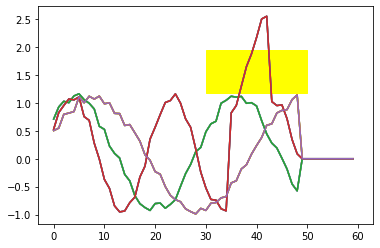

1/1 [==============================] - 0s 27ms/step
[False False  True False False]
[1.6756589e-05 9.2055961e-06 6.8931045e-06 4.9772807e-06 6.9570929e-06
 9.4614670e-06]
[4.68947037e-05 1.56304217e-03 1.56564987e-04 7.88495381e-05
 9.51889015e-05 1.21716665e-04]
[3.4112408e-04 9.9998677e-01 1.7250823e-04 4.5431481e-04 6.8297272e-04
 3.9805102e-04]
[8.9148698e-06 7.8466810e-06 2.9993633e-05 8.4279787e-07 2.7054773e-06
 7.7276018e-06]
[1.7617723e-06 1.6898257e-05 9.4607194e-06 4.3948176e-06 1.5800633e-05
 3.3968131e-06]


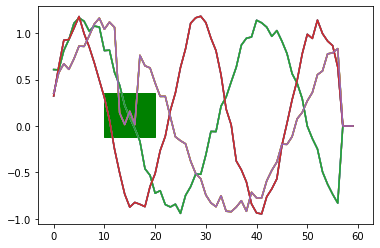

1/1 [==============================] - 0s 28ms/step
[False False False False  True]
[1.0992573e-05 8.3790197e-05 6.8322192e-06 5.9604690e-06 3.7220468e-06
 2.3007017e-06]
[7.7190554e-05 2.0878731e-04 1.8819697e-04 1.5043121e-04 1.2075403e-04
 6.8558526e-05]
[0.00037697 0.02144195 0.00038774 0.00039546 0.0004148  0.00069647]
[5.6778194e-06 9.4703146e-06 9.8043552e-07 1.7314477e-06 1.0487645e-06
 8.4258005e-07]
[4.3158234e-06 9.9996436e-01 5.3584045e-06 1.7862350e-05 9.0748999e-06
 1.8824958e-05]


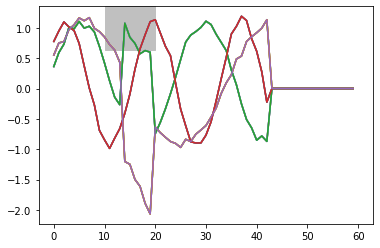

1/1 [==============================] - 0s 22ms/step
[ True  True False False False]
[3.7157886e-05 9.9999630e-01 2.5356128e-06 1.1538694e-05 3.0805563e-06
 4.0606878e-06]
[9.9988031e-01 2.2863394e-04 5.9585442e-04 2.1693835e-04 5.4264732e-05
 5.0441944e-05]
[0.00229173 0.00047925 0.00043161 0.00086647 0.00062501 0.00044968]
[1.3562724e-05 3.3865712e-05 2.3220414e-06 7.0259756e-07 6.5567438e-06
 1.0710132e-06]
[8.2004117e-06 1.4644091e-06 3.2765449e-05 2.9081887e-06 6.2899503e-06
 7.9632191e-06]


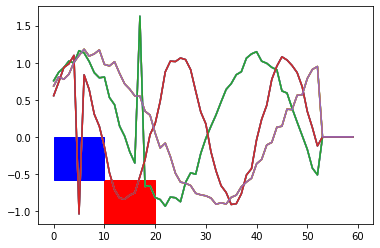

1/1 [==============================] - 0s 24ms/step
[False False  True False False]
[1.7435170e-05 9.9169367e-05 3.4210232e-06 4.5898596e-06 1.2189328e-05
 5.6236186e-06]
[1.8863514e-04 6.5500855e-05 1.2328732e-04 1.2534385e-04 9.3402268e-05
 2.6663320e-05]
[9.9997127e-01 3.1199830e-03 2.3241855e-04 3.3776247e-04 6.5412943e-04
 6.8404683e-04]
[6.8835483e-04 4.1254448e-06 2.2331802e-05 7.2057531e-07 5.3534854e-06
 2.2441720e-06]
[1.0335441e-05 8.8604220e-06 9.5391033e-06 4.7238068e-06 1.3608512e-05
 3.6427079e-07]


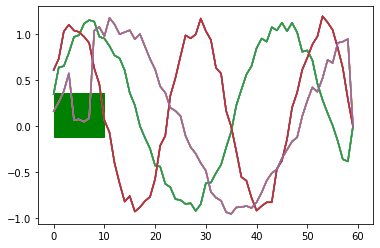

1/1 [==============================] - 0s 25ms/step
[False  True  True False  True]
[5.2609817e-06 1.0066460e-05 5.2721455e-04 6.4035689e-06 8.7756634e-06
 2.8088118e-06]
[3.9430404e-05 9.0357731e-05 9.9548292e-01 1.1228719e-04 3.0999046e-05
 7.8791738e-05]
[9.7949900e-02 1.1923267e-03 9.9940598e-01 9.7416871e-04 5.6978757e-04
 5.1336089e-04]
[7.1461938e-05 1.5567766e-05 4.8684369e-06 7.2387172e-07 1.9105025e-06
 9.0752201e-07]
[9.9998212e-01 7.2316843e-06 3.8046248e-05 4.1714952e-06 2.6429336e-06
 9.0006561e-06]


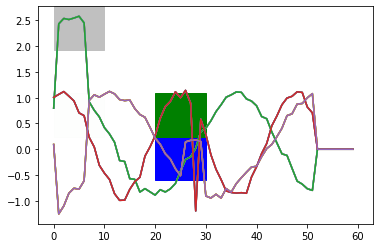

1/1 [==============================] - 0s 36ms/step
[False  True False False False]
[1.9028410e-05 8.3258474e-06 8.1913213e-06 5.5580545e-06 3.1702484e-06
 2.3007017e-06]
[9.9166042e-01 1.2683992e-04 1.8316074e-04 1.1186100e-04 7.7347351e-05
 6.8558526e-05]
[0.00030749 0.00018891 0.00076223 0.00048065 0.00051661 0.00069647]
[4.0402363e-05 2.7049584e-05 6.9136451e-07 1.1969958e-06 8.4274956e-07
 8.4258005e-07]
[1.9609091e-05 9.7927696e-06 2.7916108e-06 1.1268609e-05 9.0854292e-06
 1.8824958e-05]


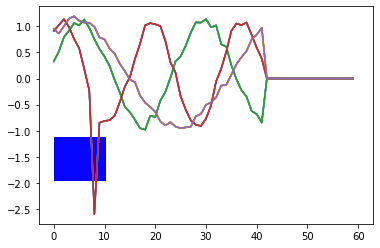

1/1 [==============================] - 0s 25ms/step
[ True False False False False]
[1.5341111e-05 8.5128895e-06 1.9949371e-06 1.1532356e-05 9.4673796e-06
 9.9998152e-01]
[6.0012899e-05 8.5966793e-05 2.5164441e-04 2.3934203e-04 1.4498333e-05
 3.0408155e-05]
[0.00028758 0.00193474 0.00038156 0.00111103 0.00144962 0.00047639]
[9.3103072e-06 9.1162764e-07 1.4619683e-05 1.0630820e-06 1.6210812e-06
 7.9138272e-06]
[3.3202502e-06 1.1199679e-06 2.5006666e-05 5.8645196e-06 7.7838791e-07
 5.3267871e-07]


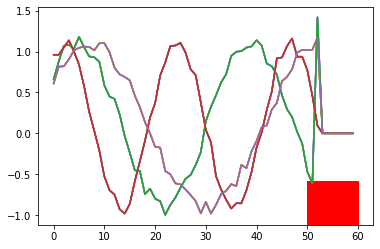

1/1 [==============================] - 0s 24ms/step
[False False False False False]
[1.9005813e-05 4.0479801e-05 4.4638596e-06 6.9499833e-06 1.2287975e-05
 6.7703677e-06]
[2.8792161e-05 8.9855253e-05 7.0381539e-05 1.7265978e-04 7.8337871e-05
 3.6836365e-05]
[0.00046775 0.00128247 0.00023395 0.00036393 0.0005503  0.00086348]
[6.33933769e-06 6.15353338e-06 2.33127957e-05 5.83115821e-07
 1.06513435e-05 3.81414020e-06]
[7.0691715e-07 7.6199449e-06 9.9833424e-06 3.8000717e-06 1.1552017e-05
 8.7055508e-07]


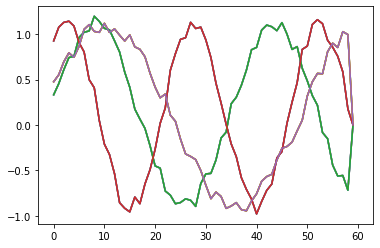

1/1 [==============================] - 0s 33ms/step
[ True False False False False]
[7.8296753e-06 1.2579649e-05 9.9999857e-01 4.4524568e-06 3.1651855e-06
 2.3007017e-06]
[1.4329184e-04 7.0135720e-05 8.3092030e-04 1.2765640e-04 1.4201591e-04
 6.8558526e-05]
[0.00023422 0.0002878  0.00077518 0.00028172 0.00086115 0.00069647]
[5.9731810e-06 1.4355016e-05 2.3011204e-05 3.0888023e-06 1.1809717e-06
 8.4258005e-07]
[9.6252479e-06 1.4092960e-06 1.0650759e-06 1.3271689e-05 2.0125222e-05
 1.8824958e-05]


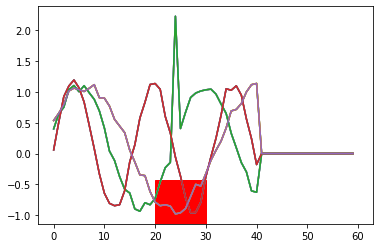

1/1 [==============================] - 0s 31ms/step
[False False False  True  True]
[6.4337960e-06 7.6403485e-06 9.4191355e-06 9.1948914e-06 2.8156371e-06
 2.3007017e-06]
[1.7100612e-04 9.2127244e-05 6.7598671e-03 5.5683042e-05 4.6917477e-05
 6.8558526e-05]
[0.00436571 0.00049824 0.00011601 0.00257369 0.0004379  0.00069647]
[1.1685648e-04 5.0877816e-06 9.9999225e-01 8.1065127e-06 7.9398633e-06
 8.4258005e-07]
[9.9999321e-01 3.2528624e-06 4.5001660e-05 5.2519040e-06 9.4140714e-06
 1.8824958e-05]


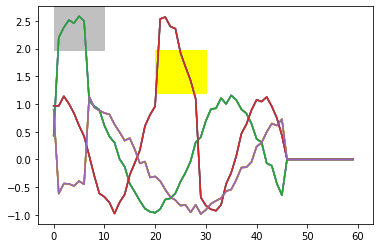

1/1 [==============================] - 0s 24ms/step
[False False False False False]
[1.04808632e-05 7.26901499e-06 1.03774355e-05 9.37704772e-06
 3.81510108e-06 2.30070168e-06]
[9.52607224e-05 5.37322267e-05 4.95749991e-04 1.15875024e-04
 3.49772235e-05 6.85585255e-05]
[0.00031107 0.00026154 0.00047308 0.00034177 0.0004675  0.00069647]
[1.3113870e-05 7.7227533e-06 1.2300579e-06 8.2683855e-06 1.9516258e-06
 8.4258005e-07]
[8.1915559e-06 2.2840084e-06 5.3474391e-06 2.1555175e-05 5.2315881e-06
 1.8824958e-05]


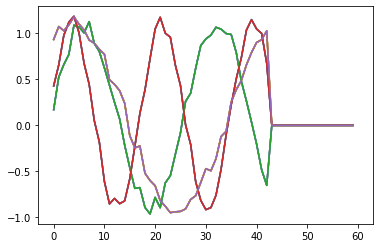

1/1 [==============================] - 0s 23ms/step
[ True  True False False False]
[9.9994242e-01 9.6527701e-06 2.8704337e-06 1.2283242e-05 9.2202681e-06
 3.8064659e-06]
[9.9947482e-01 5.5369517e-05 4.3220836e-04 8.9736882e-04 2.0975314e-05
 3.4313583e-05]
[0.00074313 0.00160828 0.00044649 0.00684407 0.00140281 0.00051853]
[1.1416899e-05 1.3854756e-06 5.3919912e-06 6.2027260e-07 1.4189047e-06
 2.1250398e-06]
[7.2273961e-06 2.2753904e-06 2.3933755e-05 3.5011246e-06 1.1155803e-06
 5.9190502e-06]


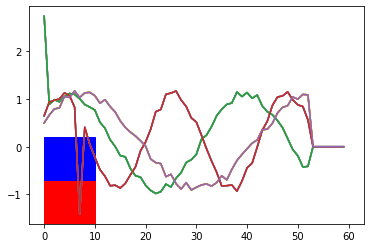

In [43]:
for k in np.random.randint(0, len(test_x), 20):
    pred = model2.predict(test_x[k][None, ...])
    print(test_y[k])
    for z in [0, 1, 2, 3, 4]:
        colors = pred[0, ..., z]
        print(colors)
        plt.plot(test_x[k])
        for i, q in enumerate(colors):
            plt.axvspan(i*10, i*10+10, ymin=z/5, ymax=(z+1)/5,
                        color={1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5:'silver'}[z+1], alpha=q**2)
    plt.show()
    
